<a href="https://colab.research.google.com/github/sejli/cse158as2/blob/main/cse158as2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import csv
import random
import matplotlib.pyplot as plt

In [2]:
def readCSV(path):
    f = open(path)
    c = csv.reader(f)
    header = ['user_id', 'stream_id', 'streamer_username', 'time_start', 'time_stop']
    for l in c:
        d = dict(zip(header,l))
        yield d

In [3]:
# Load dataset and count the number of watched streams by each user
# Users are listed numerically in ascending order
dataset = []
for l in readCSV('100k_a.csv'):
  dataset.append(l)

In [4]:
# Split training and validation sets as follows: 
#   - Training set contains all of the streams each users watch that are not the most recent
#   - Validation set contains the most recent stream that each user has watched as well as
#     a random stream that each user has not watched (positive and negative validation sets)
train = []
valid = []
u = dataset[0]['user_id']
for i in range(len(dataset)):
  if dataset[i]['user_id'] != u:
    valid.append((dataset[i]))
    u = dataset[i]['user_id']
  else:
    train.append(dataset[i])
  if i == len(dataset) - 1:
    valid.append(dataset[i])

In [6]:
# Create full validation sets with positive and negative
userSet = set()
streamerSet = set()
watchedSet = set()

for d in train:
  u = d['user_id']
  s = d['streamer_username']
  userSet.add(u)
  streamerSet.add(s)
  watchedSet.add((u,s))

streamers = list(streamerSet)
watched_valid = set()
not_watched_valid = set()
for d in valid:
  u = d['user_id']
  s = d['streamer_username']
  b = random.choice(streamers)
  while (u, b) in watched_valid or (u, b) in not_watched_valid:
    b = random.choice(streamers)
  not_watched_valid.add((u, b))
  watched_valid.add((u, s))

X_valid = [(1, watched_valid), (0, not_watched_valid)]
y_valid = [1 for i in range(len(watched_valid))] + [0 for i in range(len(not_watched_valid))]

In [7]:
len(train)

2951734

In [8]:
# Baseline: Return watched if the streamer is in the top 50th percentile of streamers
streamer_count = defaultdict(int)
total_streamers = 0
for d in train:
  streamer_count[d['streamer_username']] += 1
  total_streamers += 1

mostPopular = [(streamer_count[s], s) for s in streamer_count]
mostPopular.sort(reverse = True)

percentile = set()
count = 0
for i, streamer in mostPopular:
  count += i
  percentile.add(streamer)
  if count > math.floor(total_streamers / 2): break

predictions = []
for label, sample in X_valid:
  for u, s in sample:
    if s in percentile:
      predictions.append(1)
    else:
      predictions.append(0)
print(sum(np.array(predictions) == np.array(y_valid)) / (len(y_valid)))

0.75093


Best Threshold: 85
Best Accuracy: 0.87007


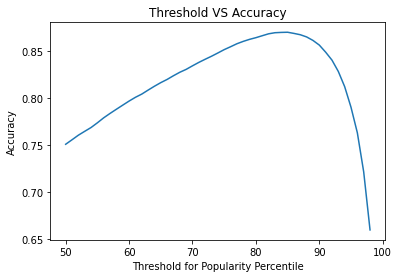

In [10]:
# This is already pretty high, but can we improve it?
# Find a threshold by looping through the percentiles from 50 to 99
X = [i for i in range(50,99)]
y = []
best_accuracy = 0
best_threshold = 0
for threshold in range(50, 99):
  percentile = set()
  count = 0
  for i, streamer in mostPopular:
    count += i
    percentile.add(streamer)
    if count > math.floor(total_streamers * (threshold / 100)): break

  predictions = []
  for label, sample in X_valid:
    for u, s in sample:
      if s in percentile:
        predictions.append(1)
      else:
        predictions.append(0)
  accuracy = sum(np.array(predictions) == np.array(y_valid)) / (len(y_valid))
  y.append(accuracy)
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_threshold = threshold
print('Best Threshold:', best_threshold)
print('Best Accuracy:', best_accuracy)
plt.plot(X, y)
plt.xlabel('Threshold for Popularity Percentile')
plt.ylabel('Accuracy')
plt.title('Threshold VS Accuracy')
plt.show()

In [11]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer / denom
    else:
        return 0

In [12]:
# Given the set Su (Set of all stream usernames that the user has watched in the training set)
# for a user U, compare Jaccard similarities between Su and Si where i is every other user
# Predict 1 if the similarity is above a certain threshhold, 0 otherwise
usersPerStreamer = defaultdict(set)
streamersPerUser = defaultdict(set)

for d in train:
  u = d['user_id']
  s = d['streamer_username']
  usersPerStreamer[s].add(u)
  streamersPerUser[u].add(s)

In [18]:
# Calculate similarities for everything so we don't have to calculate every time we run
sims = defaultdict(int)
for label, sample in X_valid:
  for u, s in sample:
    users = usersPerStreamer[s]
    for s2 in streamersPerUser[u]:
      sim = Jaccard(users, usersPerStreamer[s2])
      sims[(u, s, s2)] = sim

In [19]:
# Max Sim = 0.01
predictions = []
for label, sample in X_valid:
  for u, s in sample:
    maxSim = 0
    users = usersPerStreamer[s]
    for s2 in streamersPerUser[u]:
      sim = sims[(u, s, s2)]
      if sim > maxSim:
        maxSim = sim
    if maxSim > 0.01:
      predictions.append(1)
    else:
      predictions.append(0)
accuracy = sum(np.array(predictions) == np.array(y_valid)) / (len(y_valid))
print(accuracy)

0.934295


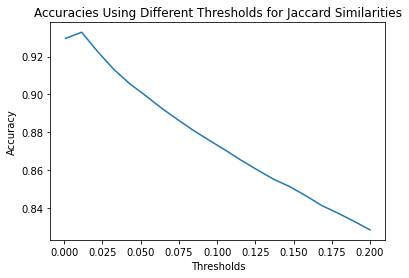

In [27]:
X = np.linspace(0.001, 0.2, 20)
y = []
for threshold in X:
  predictions = []
  for label, sample in X_valid:
    for u, s in sample:
      maxSim = 0
      users = usersPerStreamer[s]
      for s2 in streamersPerUser[u]:
        sim = sims[(u, s, s2)]
        if sim > maxSim:
          maxSim = sim
      if maxSim > threshold:
        predictions.append(1)
      else:
        predictions.append(0)
  y.append(sum(np.array(predictions) == np.array(y_valid)) / (len(y_valid)))
plt.plot(X, y)
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.title('Accuracies Using Different Thresholds for Jaccard Similarities')
plt.show()